In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')

In [4]:
import os
import pickle
import random
from glob import glob
import config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

## Analysis pipeline:
-  What are best/worst predictions visualization?
-  How the segmentation map is changing over levels? Which maps improve, which get worse or stay constant with stacking?
-  Does the 2nd level converge faster than the first level? 
-  Is the semantic part of the input used at all or mostly ignored, e.g. what happens when you distort the semantic input? etc

## Sections
[Softmax](#Softmax)


[Semantic](#Semantic)

In [20]:
from src.helpers import read_metrics

from src.main import calculate_stat
from src.main import plot_pair_metrics_with_error
from src.main import plot_level_metrics


from src.analyze import plot_metrics_with_stderror
from src.analyze import calculate_iou_score
from src.analyze import compare_iou_scores
from src.analyze import get_top_n_predictions, visualize_best_worst_predictions
from src.analyze import plot_stacked_bar

from src.utils import get_image_name_from_path

In [37]:
project_root = '/Users/abalgabekova/Desktop/Akerke/stacked-unets'
data_dir = os.path.join(project_root,'dataset', 'data-etci-flood','train')

In [38]:
def plot_comparison(results):
    for transition, counts in results.items():
        labels = ['Improved', 'Worsened', 'Constant']
        values = [len(counts['improved']), len(counts['worsened']), len(counts['constant'])]
        plt.bar(labels, values)
        plt.title(f'IoU Changes from {transition}')
        plt.xlabel('Change Type')
        plt.ylabel('Count')
        plt.show()

# Softmax

In [39]:
output_type = 'softmax'
output_dir = os.path.join(project_root, f'output_{output_type}')

In [40]:
metrics = read_metrics(f'{output_dir}/merged_metrics.pkl')

In [41]:
for level in range(5):
    print(f"Level: {level + 1}")
    level_key = f'level{level}'
    for metric_name in metrics:
        mean_val, std_val = calculate_stat(metrics, metric_name, level_key)
        if mean_val and std_val:
            print(f"Mean {metric_name}: {mean_val:.2f} +/- {std_val:.2f}")

Level: 1
Mean train_loss: 0.05 +/- 0.01
Mean val_loss: 0.05 +/- 0.02
Mean train_iou: 0.71 +/- 0.04
Mean val_iou: 0.71 +/- 0.05
Mean test_iou: 0.73 +/- 0.01
Mean timing: 2066.85 +/- 345.26
Mean entropy: 0.04 +/- 0.00
Level: 2
Mean train_loss: 0.04 +/- 0.01
Mean val_loss: 0.04 +/- 0.01
Mean train_iou: 0.77 +/- 0.04
Mean val_iou: 0.74 +/- 0.08
Mean test_iou: 0.76 +/- 0.03
Mean timing: 7295.18 +/- 1349.87
Mean entropy: 0.03 +/- 0.00
Level: 3
Mean train_loss: 0.04 +/- 0.01
Mean val_loss: 0.04 +/- 0.01
Mean train_iou: 0.77 +/- 0.04
Mean val_iou: 0.74 +/- 0.07
Mean test_iou: 0.78 +/- 0.00
Mean timing: 7243.67 +/- 1320.21
Mean entropy: 0.02 +/- 0.00
Level: 4
Mean train_loss: 0.04 +/- 0.01
Mean val_loss: 0.04 +/- 0.01
Mean train_iou: 0.77 +/- 0.04
Mean val_iou: 0.75 +/- 0.06
Mean test_iou: 0.76 +/- 0.03
Mean timing: 7230.58 +/- 1309.33
Mean entropy: 0.03 +/- 0.01
Level: 5
Mean train_loss: 0.04 +/- 0.01
Mean val_loss: 0.04 +/- 0.01
Mean train_iou: 0.77 +/- 0.04
Mean val_iou: 0.75 +/- 0.06
Mean t

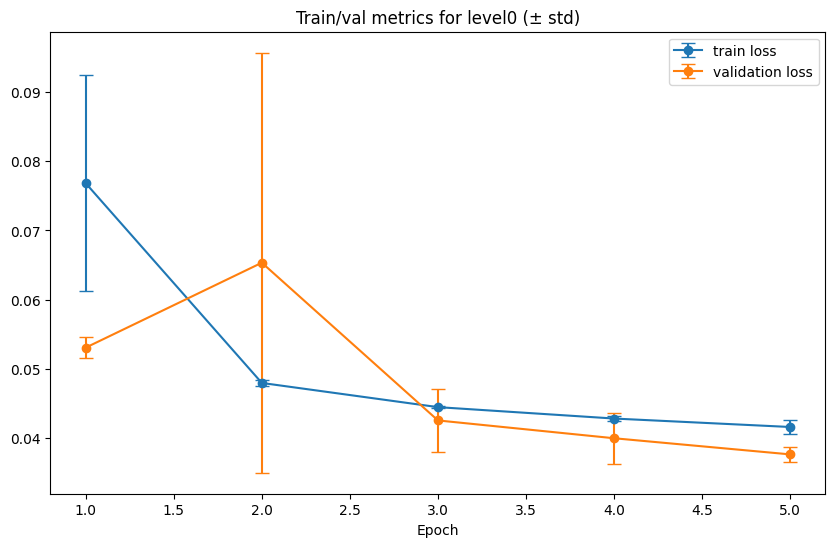

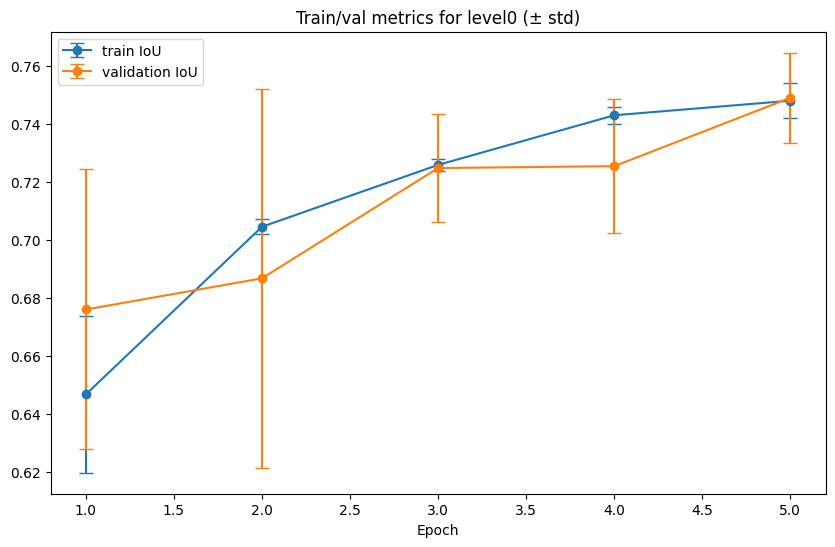

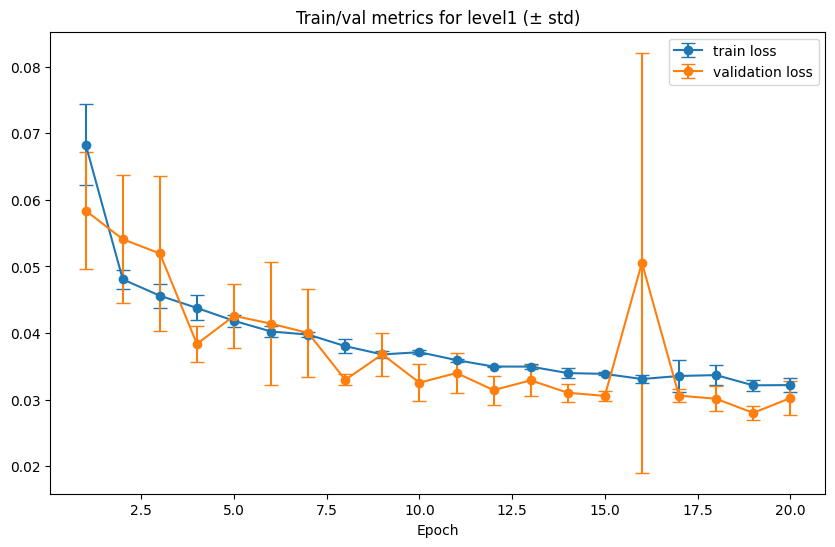

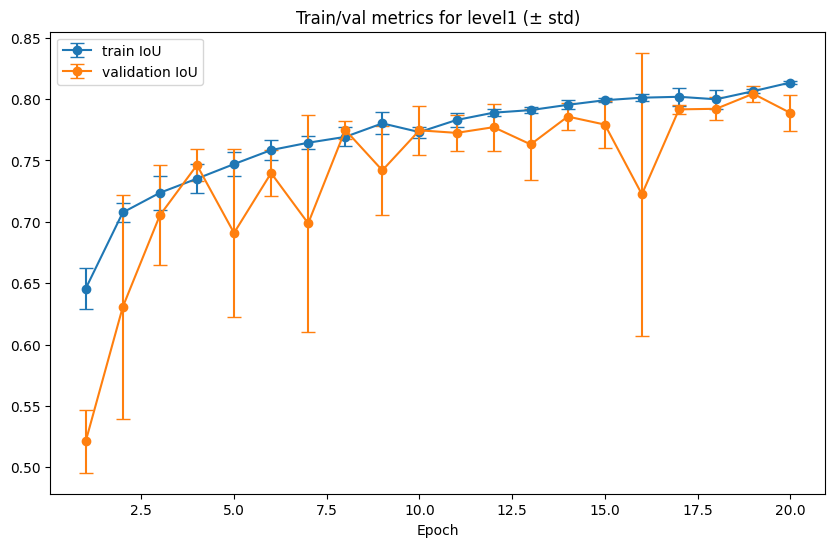

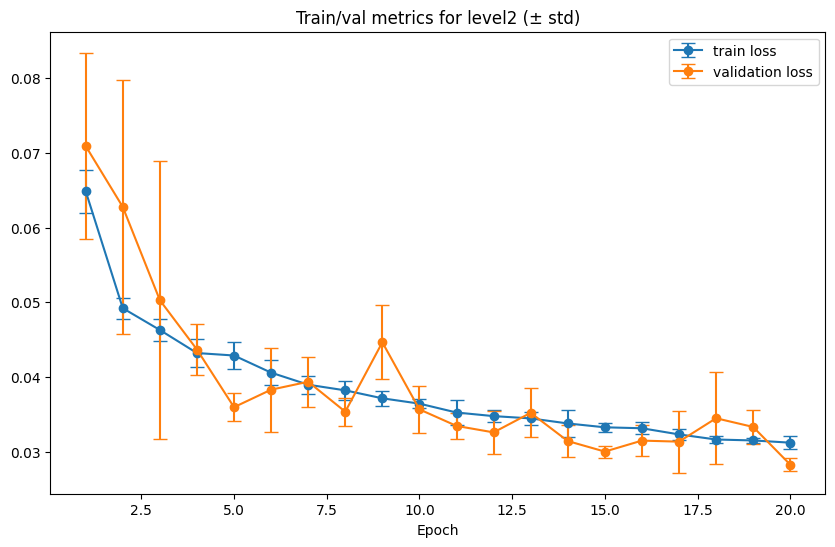

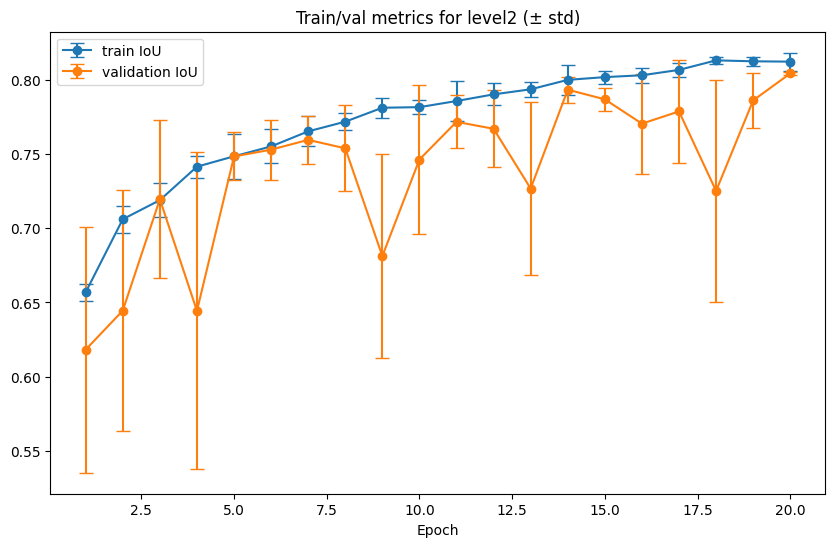

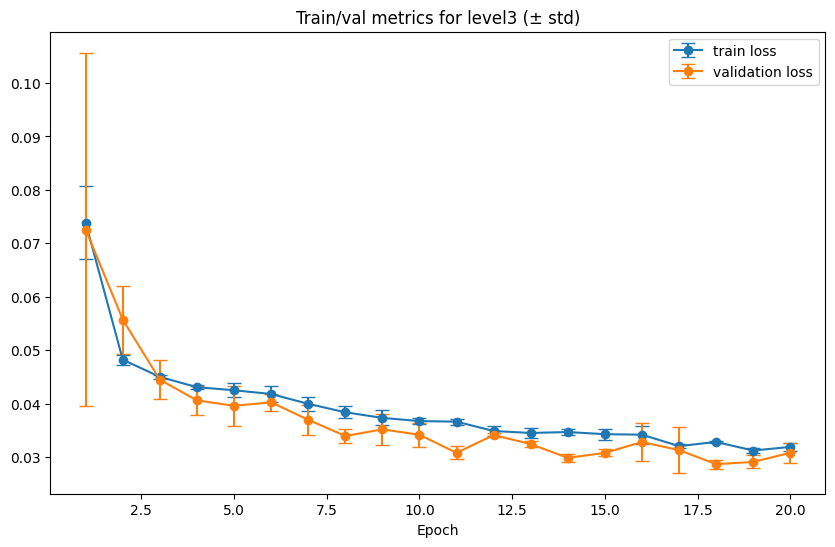

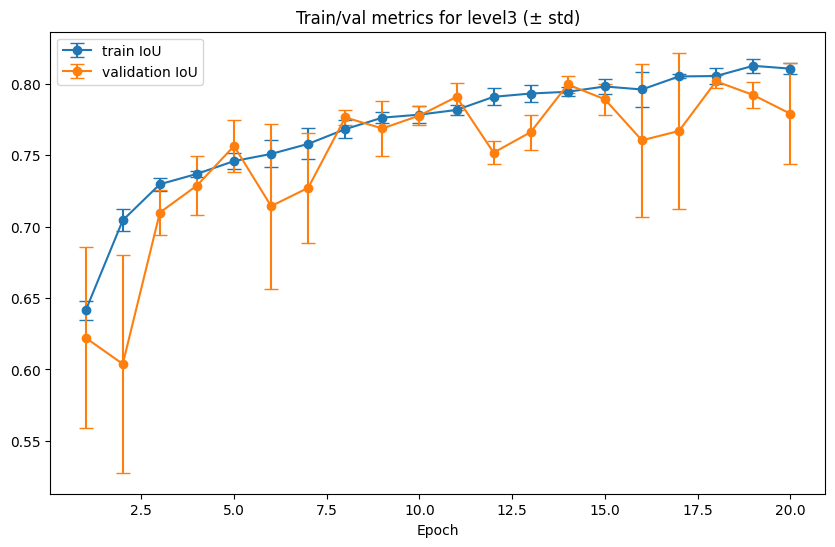

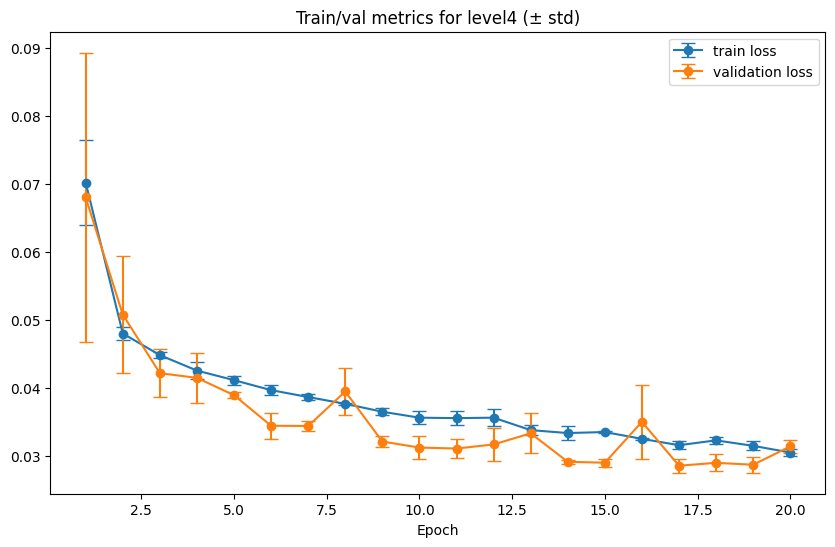

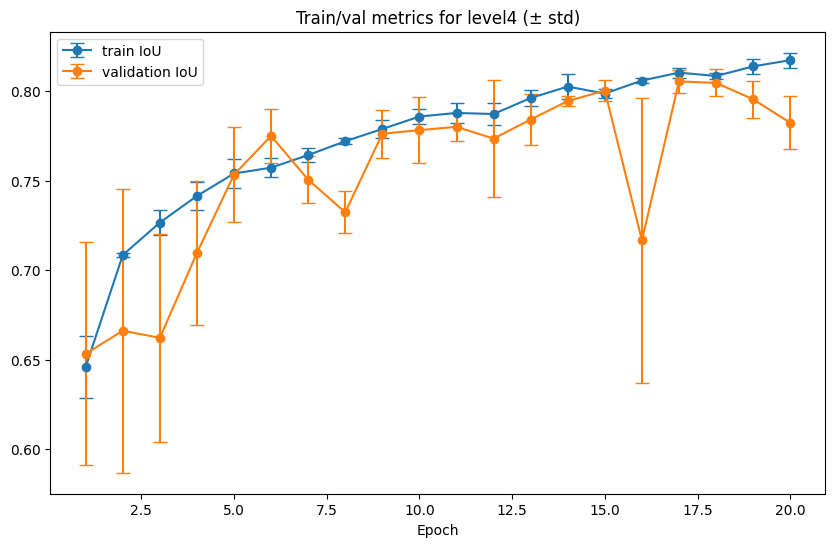

In [9]:
for level in range(5):
    plot_pair_metrics_with_error(['train_loss', 'val_loss'], metrics, level,
                                     labels=['train loss', 'validation loss'], filename='Loss')
    plot_pair_metrics_with_error(['train_iou', 'val_iou'], metrics, level,
                                     labels=['train IoU', 'validation IoU'], filename='IoU')

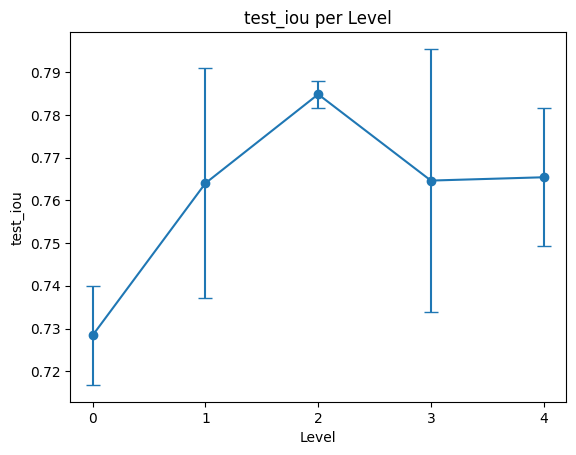

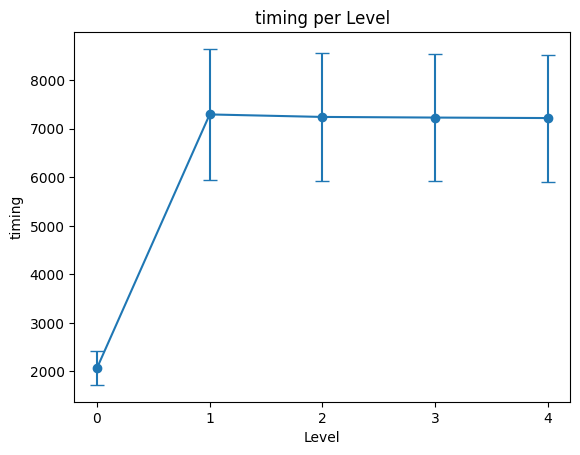

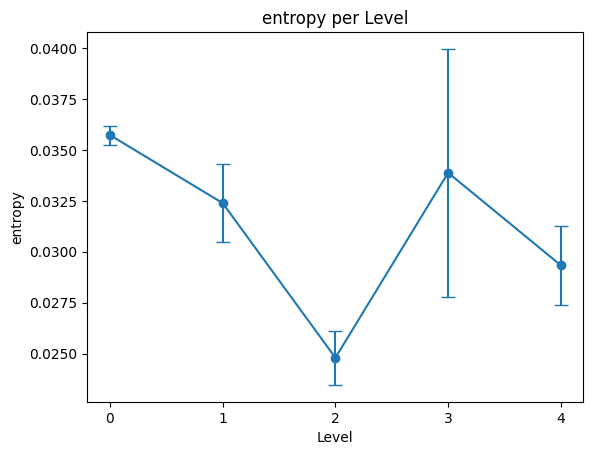

In [9]:
for metric_name in metrics:
    if metric_name in ['test_iou', 'timing', 'entropy']:
        plot_level_metrics(metrics, metric_name, 5)

In [42]:
test_iou_data = metrics.get('test_iou', {})
mean_test_iou_per_run = {}

for run, levels in test_iou_data.items():
    all_values = []
    for level, values in levels.items():
        all_values.extend(values)
    mean_value = np.mean(all_values) if all_values else None  # Handle empty lists
    mean_test_iou_per_run[run] = mean_value

print("Mean test_iou values per run:")
for run, mean_value in mean_test_iou_per_run.items():
    print(f"{run}: {mean_value}")

Mean test_iou values per run:
run0: 0.7654016864487911
run1: 0.7658479584664011
run2: 0.7530942193110495


In [43]:
RUN = 1
labels_dir = os.path.join(output_dir, f'output_{output_type}_run{RUN+1}', 'etci_labels')
labels_dir

'/Users/abalgabekova/Desktop/Akerke/stacked-unets/output_softmax/output_softmax_run2/etci_labels'

In [44]:
loaded_dict = np.load(f'{output_dir}/output_{output_type}_run{RUN+1}/test_df_run0.npy', allow_pickle=True).item()
test_df = pd.DataFrame.from_dict(loaded_dict)
test_df = test_df.reset_index(drop=True)

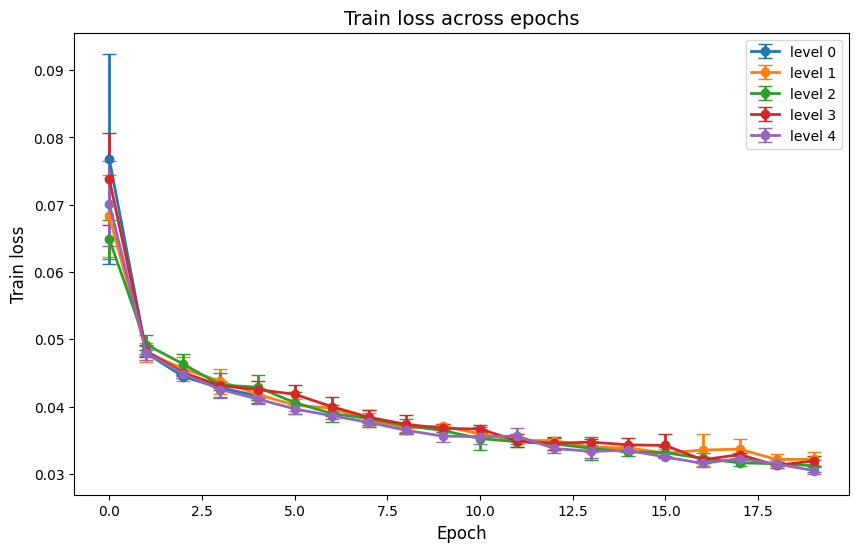

In [232]:
plot_metrics_with_stderror(metrics, metric_name='train_loss')

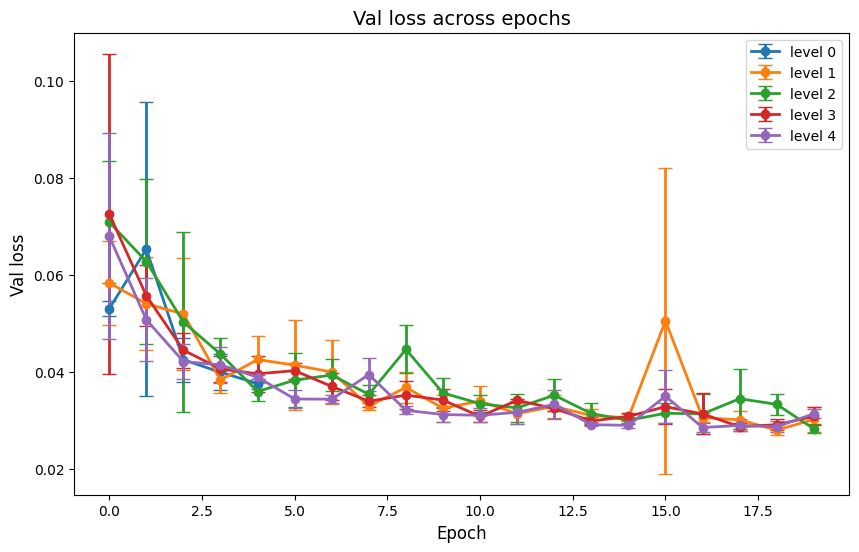

In [233]:
plot_metrics_with_stderror(metrics, metric_name='val_loss')

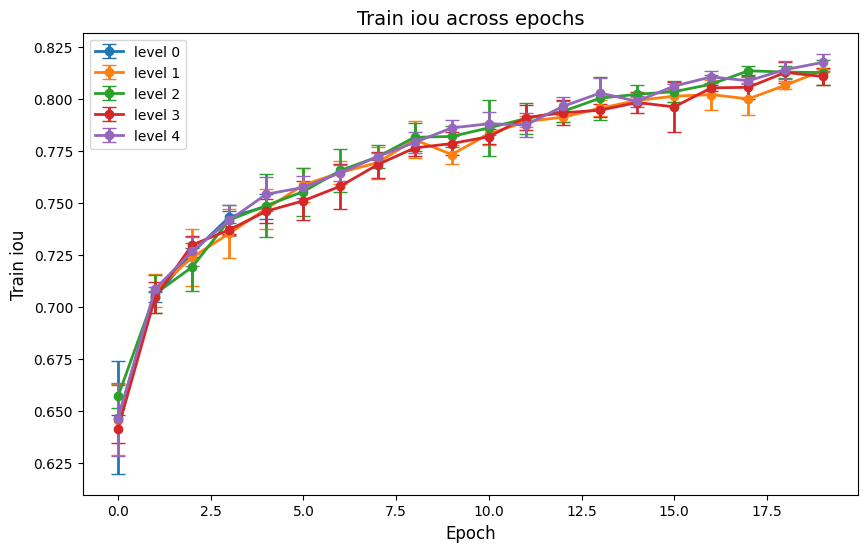

In [234]:
plot_metrics_with_stderror(metrics, metric_name='train_iou')

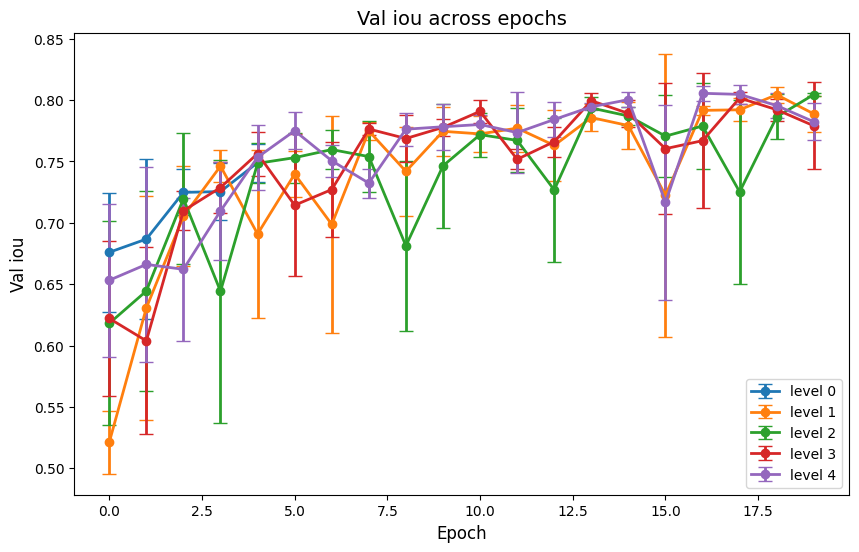

In [235]:
plot_metrics_with_stderror(metrics, metric_name='val_iou')

In [45]:
def colab_to_local(input_str):
    if '/content/stacked-unets/output' in input_str:
        input_str = input_str.replace('/content/stacked-unets/output', output_dir)
    if '/content/stacked-unets/dataset/data-etci-flood/train' in input_str:
        input_str = input_str.replace('/content/stacked-unets/dataset/data-etci-flood/train', data_dir)
    
    return input_str

In [46]:
columns_to_update = ['flood_label_path', 'water_body_label_path','semantic_map_prev_level', 'vv_image_path', 'vh_image_path', 'softmax_prob_prev_level' ]

for col in columns_to_update:
    test_df[col] = test_df[col].apply(colab_to_local)

In [47]:
import numpy as np

n_levels = 5
mean_iou_scores_per_row = []
threshold = 0.5 

for _, row in test_df.iterrows():
    true_mask_path = row['flood_label_path']
    true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)

    mean_iou_scores_per_level = {}

    for level in range(n_levels):
        prediction_image_name = get_image_name_from_path(row['vv_image_path'])
        prediction_path = f"{labels_dir}/softmax_prob_level_{level}_image_{prediction_image_name}.npy"

        pred_prob = np.load(prediction_path)
        pred_mask = (pred_prob > threshold).astype(np.uint8)
        iou_score = calculate_iou_score(true_mask, pred_mask)
        
        mean_iou_score = np.nanmean(iou_score)
        mean_iou_scores_per_level[f'level_{level}'] = mean_iou_score

    mean_iou_scores_per_row.append(mean_iou_scores_per_level)


for level in range(n_levels):
    column_name = f'iou_scores_level_{level}'
    test_df[column_name] = [row[f'level_{level}'] for row in mean_iou_scores_per_row]

In [48]:
best_idx, worst_idx = get_top_n_predictions(df=test_df, n=5, level=1)

[ WARN:0@7147.693] global loadsave.cpp:248 findDecoder imread_('/Users/abalgabekova/Desktop/Akerke/stacked-unets/output/etci_labels/semantic_map_level_1_image_nebraska_20170731t002118_x-20_y-23.png'): can't open/read file: check file path/integrity


TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

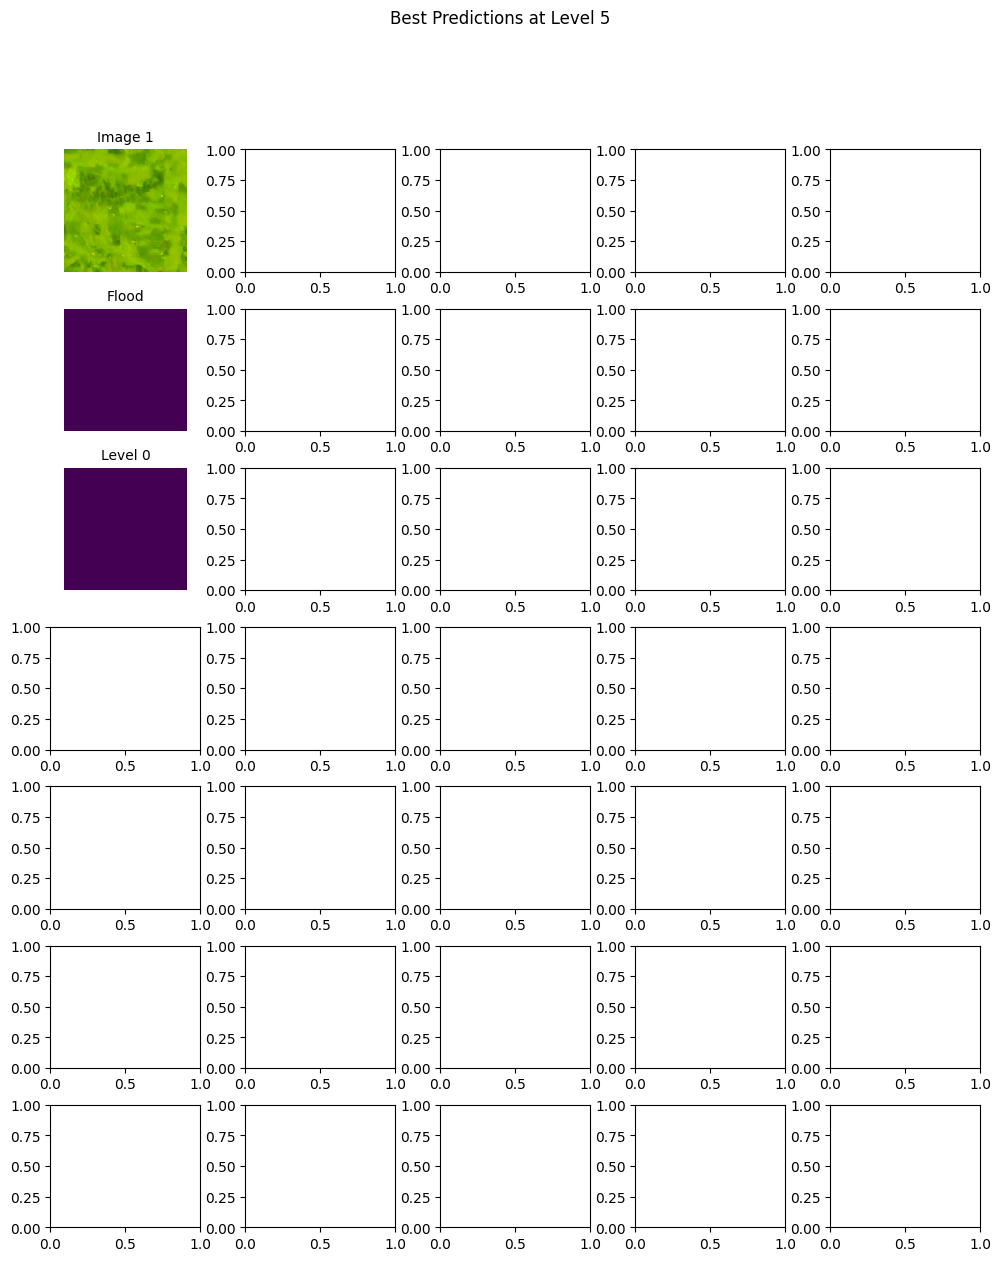

In [49]:
visualize_best_worst_predictions(test_df, best_idx, worst_idx, n_levels=5)

In [50]:
results = compare_iou_scores(df=test_df, list_of_levels=[0,1,2,3,4])

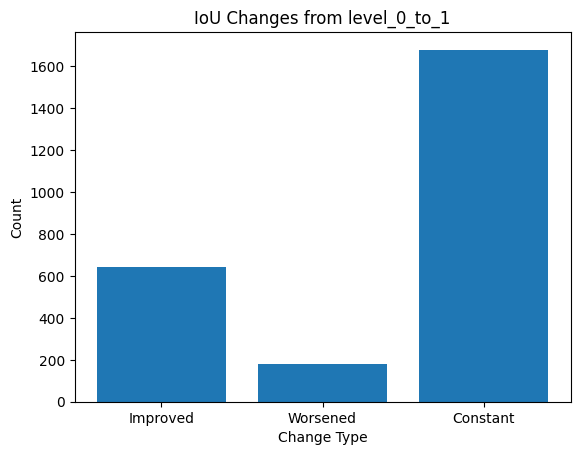

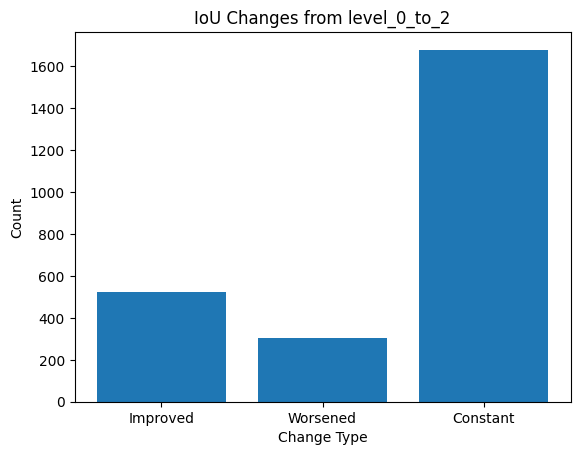

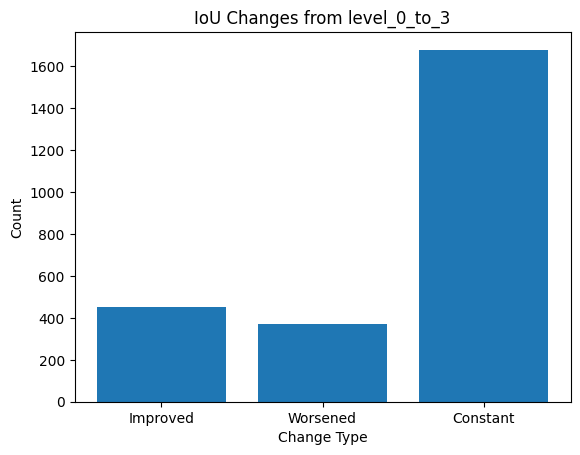

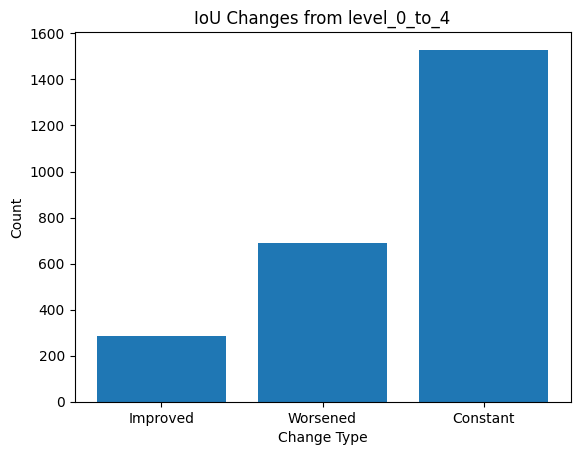

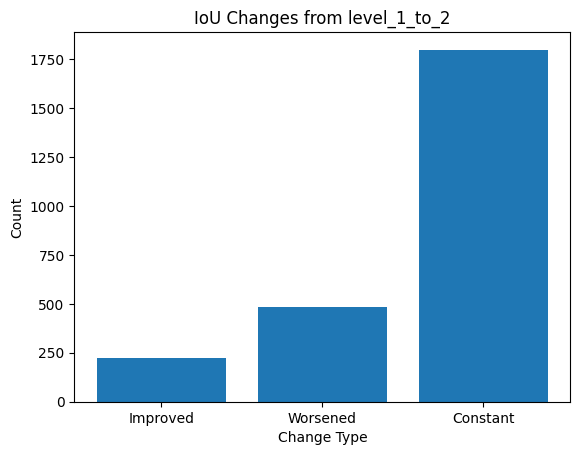

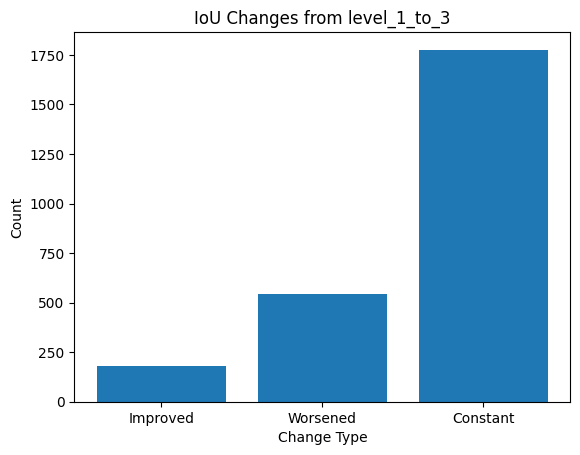

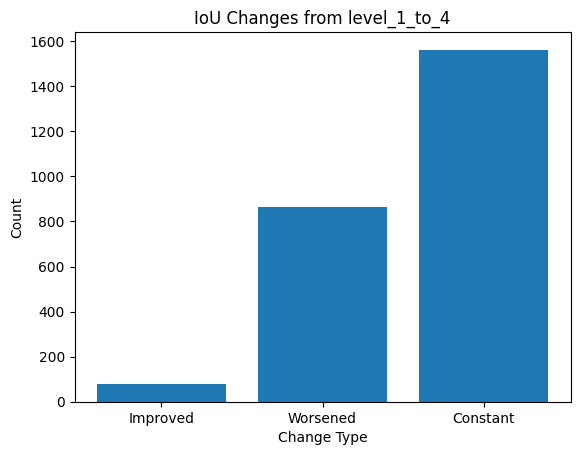

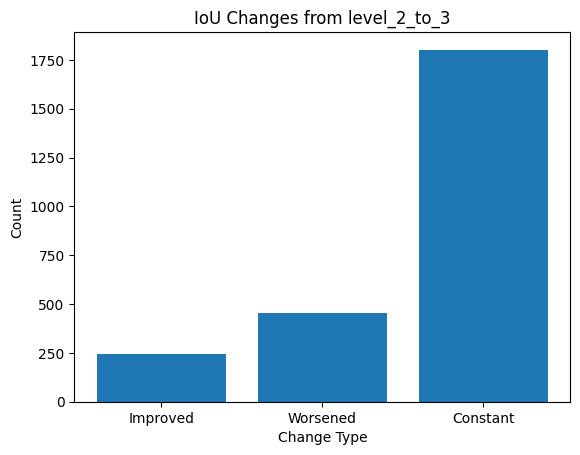

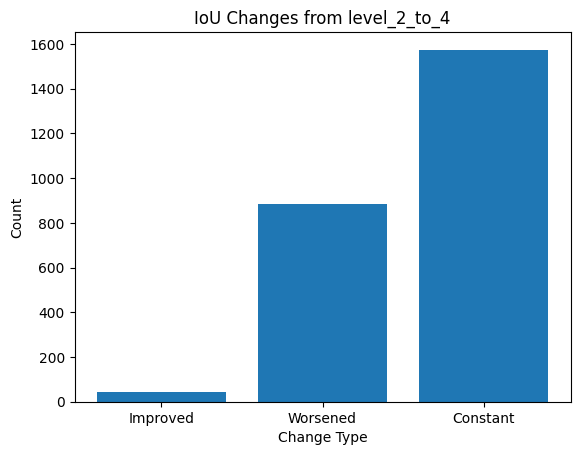

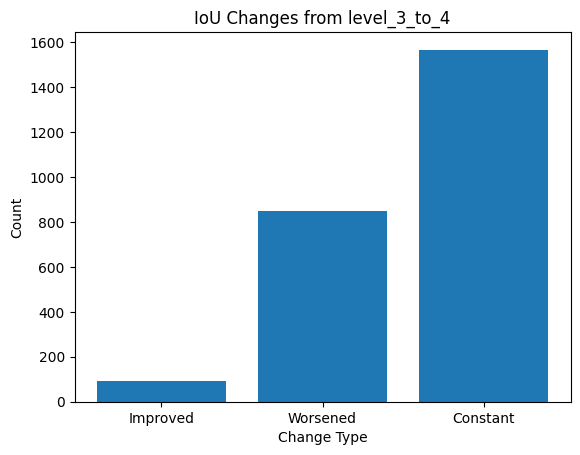

In [51]:
plot_comparison(results)

     1    2    3    4
0  461  220   85 -404
1    0 -259 -363 -783
2    0    0 -211 -839
3    0    0    0 -757


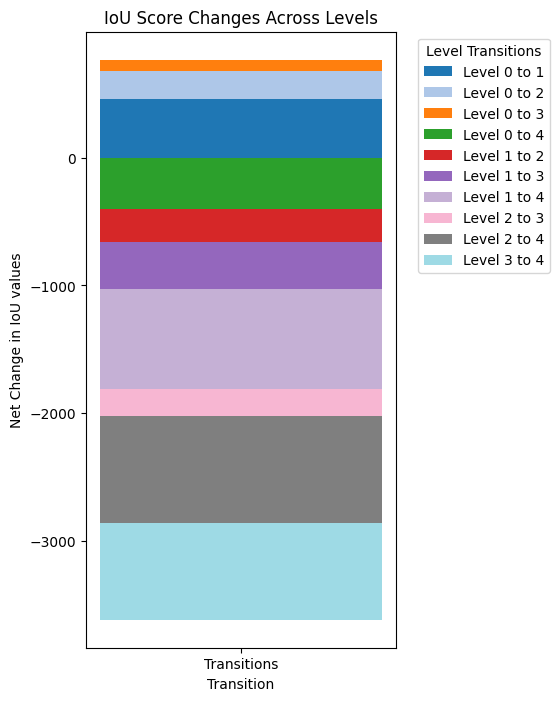

In [52]:
plot_stacked_bar(results, list_of_levels=[0, 1, 2, 3, 4])

In [53]:
show_constant(results)

level_0_to_1:1680
level_0_to_2:1679
level_0_to_3:1680
level_0_to_4:1529
level_1_to_2:1798
level_1_to_3:1776
level_1_to_4:1562
level_2_to_3:1802
level_2_to_4:1574
level_3_to_4:1566


# Semantic

In [10]:
output_type = 'semantic'
output_dir = os.path.join(project_root, f'output_{output_type}')
output_dir

'/Users/abalgabekova/Desktop/Akerke/stacked-unets/output_semantic'

In [11]:
metrics = read_metrics(f'{output_dir}/merged_metrics.pkl')

In [12]:
for level in range(5):
    print(f"Level: {level + 1}")
    level_key = f'level{level}'
    for metric_name in metrics:
        mean_val, std_val = calculate_stat(metrics, metric_name, level_key)
        if mean_val and std_val:
            print(f"Mean {metric_name}: {mean_val:.2f} +/- {std_val:.2f}")

Level: 1
Mean train_loss: 0.05 +/- 0.01
Mean val_loss: 0.05 +/- 0.01
Mean train_iou: 0.73 +/- 0.03
Mean val_iou: 0.72 +/- 0.04
Mean test_iou: 0.75 +/- 0.01
Mean timing: 6318.31 +/- 3024.23
Mean entropy: 0.04 +/- 0.01
Level: 2
Mean train_loss: 0.04 +/- 0.01
Mean val_loss: 0.04 +/- 0.02
Mean train_iou: 0.77 +/- 0.04
Mean val_iou: 0.73 +/- 0.08
Mean test_iou: 0.73 +/- 0.01
Mean entropy: 0.03 +/- 0.01
Level: 3
Mean train_loss: 0.04 +/- 0.01
Mean val_loss: 0.04 +/- 0.01
Mean train_iou: 0.78 +/- 0.04
Mean val_iou: 0.73 +/- 0.08
Mean test_iou: 0.77 +/- 0.02
Mean entropy: 0.02 +/- 0.00
Level: 4
Mean train_loss: 0.04 +/- 0.01
Mean val_loss: 0.04 +/- 0.01
Mean train_iou: 0.77 +/- 0.05
Mean val_iou: 0.74 +/- 0.08
Mean test_iou: 0.78 +/- 0.01
Mean entropy: 0.03 +/- 0.00
Level: 5
Mean train_loss: 0.04 +/- 0.01
Mean val_loss: 0.04 +/- 0.01
Mean train_iou: 0.77 +/- 0.04
Mean val_iou: 0.73 +/- 0.07
Mean test_iou: 0.69 +/- 0.11
Mean entropy: 0.04 +/- 0.00


In [ ]:
for level in range(5):
    plot_pair_metrics_with_error(['train_loss', 'val_loss'], metrics, level,
                                     labels=['train loss', 'validation loss'], filename='Loss')
    plot_pair_metrics_with_error(['train_iou', 'val_iou'], metrics, level,
                                     labels=['train IoU', 'validation IoU'], filename='IoU')

In [ ]:
for metric_name in metrics:
    if metric_name in ['test_iou', 'timing', 'entropy']:
        plot_level_metrics(metrics, metric_name, 5)

In [16]:
RUN = 0
labels_dir = os.path.join(output_dir, f'output_{output_type}_run{RUN+1}', 'etci_labels')
labels_dir

'/Users/abalgabekova/Desktop/Akerke/stacked-unets/output_semantic/output_semantic_run1/etci_labels'

In [18]:
loaded_dict = np.load(f'{output_dir}/output_{output_type}_run{RUN+1}/test_df.npy', allow_pickle=True).item()
test_df = pd.DataFrame.from_dict(loaded_dict)
test_df = test_df.reset_index(drop=True)

In [23]:
def colab_to_local(input_str):
    if '/content/stacked-unets/output' in input_str:
        input_str = input_str.replace('/content/stacked-unets/output', f"{output_dir}/output{output_type}_run{RUN+1}")
    if '/content/stacked-unets/dataset/data-etci-flood/train' in input_str:
        input_str = input_str.replace('/content/stacked-unets/dataset/data-etci-flood/train', data_dir)
    
    return input_str

In [24]:
columns_to_update = ['flood_label_path', 'water_body_label_path','semantic_map_prev_level', 'vv_image_path', 'vh_image_path' ]

for col in columns_to_update:
    test_df[col] = test_df[col].apply(colab_to_local)

In [25]:
n_levels = 5
mean_iou_scores_per_row = []

for _, row in test_df.iterrows():
    true_mask_path = row['flood_label_path']
    true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)

    mean_iou_scores_per_level = {}

    for level in range(n_levels):
        prediction_image_name = get_image_name_from_path(row['vv_image_path'])
        prediction_path = f"{labels_dir}/semantic_map_level_{level}_image_{prediction_image_name}.png"
        pred_mask = cv2.imread(prediction_path, cv2.IMREAD_GRAYSCALE)
        iou_score = calculate_iou_score(true_mask, pred_mask)
        mean_iou_score = np.nanmean(iou_score)
        mean_iou_scores_per_level[f'level_{level}'] = mean_iou_score

    mean_iou_scores_per_row.append(mean_iou_scores_per_level)

for level in range(n_levels):
    column_name = f'iou_scores_level_{level}'
    test_df[column_name] = [row[f'level_{level}'] for row in mean_iou_scores_per_row]

In [27]:
results = compare_iou_scores(df=test_df, list_of_levels=[0,1,2,3,4])

     1    2    3    4
0 -383 -143  532  497
1    0  436  875  819
2    0    0  886  872
3    0    0    0  105


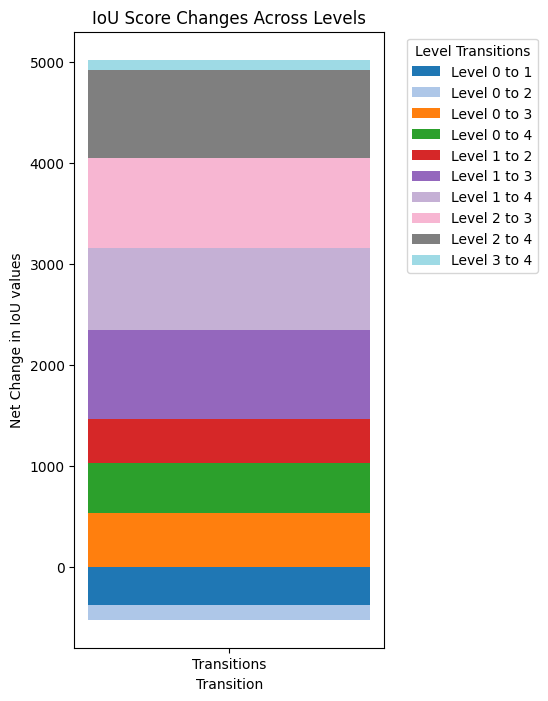

In [28]:
plot_stacked_bar(results, list_of_levels=[0, 1, 2, 3, 4])

In [34]:
def show_constant(results):
    for transition, counts in results.items():
        values = len(counts['constant'])
        print(f"{transition}:{values}")

In [35]:
show_constant(results)

level_0_to_1:1444
level_0_to_2:1422
level_0_to_3:1517
level_0_to_4:1496
level_1_to_2:1473
level_1_to_3:1586
level_1_to_4:1562
level_2_to_3:1523
level_2_to_4:1519
level_3_to_4:1738
